## 1. Read images and save data for training 

Author: Gayathri Nadar, SCF MPI-CBG </br>
Date: 2021-09-24 </br>
For: Rudrarup </br>
Lab: Tang </br> 

***THIS is an extra analysis workflow***, not shared with user but used for training the classifier with additional data. 
- We have more data from `droplet` and `aggregates` class than in `empty` class. So we use data augmentation to synthetically create 450 more datasets from 150 datasets for `empty` class. 
- Finally, we use 600 images from each class to train the classifier.

### About 
- This notebook is a part of 3 notebooks in sequence:
    * 1_read_images_augment
    * 2_train_save_classifier 
    * 3_do_prediction 
- This notebook **reads images from file paths specified in text files and populates a numpy array.**
- **Label arrays are also created** for the training data. 
- **The training data and the labels are saved in the form of numpy arrays** for fast loading in the next step. 


### Preparations
Data:

- **Prepare 3 text files such that it contains path of images of the 3 classes**
    - empty 
    - droplets
    - non-droplets
- **Save them locally in a single folder. This folder should contain only these 3 text files.** 
- **The 3 files should have file names that contain the keywords `Empty`, `Droplet`, `Non-droplet`** respectively. For e.g. `Empty_paths.txt`. No spaces in filenames!
- **Mount the server space `tanglab-tds` on your laptop** before running this notebook. 

Python:

- **Keep this jupyter notebook and `functions.py` together!**
- Set up python and jupyter, and conda env. Check document 'Readme_Python_installation'.
- **When you open this notebook. Click on Kernel > Change kernal and change it to 'imageclassification'**

### General Jupyter Notebook Usage: The basics
- The notebook is executed cell-by-cell.
- The active/current cell is visible by being surrounded by a blue or green box.
- Green box: edit mode. Blue box: view mode. To exit the edit mode: press Esc
- To run a cell: Press Shift+Enter (runs the cell and automatically advances to the next cell)
- Auto-complete is supported (convenient when you e.g. type a folder location): start typing, then press Tab key.
- When you are completely finished: Click on Kernel->Shutdown and close all notebooks related tabs.
- **If you want to do a fresh start of the analysis: click on Kernel -> Restart and Clear Output**. Do this if your notebook seems to have hung. 

### Usage of this notebook:
- Start at the top.
- Run cells step-by-step.
- For cells titled **\"User Input\"**. Adjust the content (data folder etc.) before running them.
- Note: if you accidentally ran it already, simply click on it, adjust the content, and run it again.

### Current workflow 
User Input:

- Folder containing the 3 text files. 
- Number of images to be used for training. 

Steps:

- The text files are read from the folder and added to a list. 
- From each text file, image paths are read and added to another list. 
- Next images from the path and opened and added to a numpy array. 
- N random images are chosen for training where N is set by user. 
- Array with labels `droplet`, `empty`, `aggregates` are created automatically. 
- The images and labels are saved as numpy arrays in folder `training_data` in same folder containing text files (specified by user)


### Output 
Found in the folder `training_data`
- 1 numpy array of images from each of the 3 classes 
- 1 numpy array of labels for each class

    
    

### Prep: Always run this cell

In [1]:
import numpy as np 
import os
from os.path import join
import matplotlib.pyplot as plt
import cv2
import tifffile 
import random
from skimage.transform import rotate,rescale
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from functions import * 

### User Input 
Enter the path to the folder which contains text files with paths to images. 

In [2]:
# enter values here 
path_to_txt_files = "../data/"

# nothing to do here
savepath = join(path_to_txt_files, "training_data")
if not os.path.exists(savepath):
    os.makedirs(savepath)
seed = 5

### Finding text file corresponding to each class 

In [3]:
txtfiles = [f for f in os.listdir(path_to_txt_files) if os.path.isfile(join(path_to_txt_files,f)) and f.endswith(".txt")]
print("Found text files in folder =", txtfiles, "\n")

# file with specified keywords 
emptysample_file = getFilename(txtfiles, "Empty")
dropletssample_file = getFilename(txtfiles, "Droplet")
aggregatessample_file = getFilename(txtfiles, "Non-droplet")

print("Found text files =", emptysample_file, dropletssample_file, aggregatessample_file)

Found text files in folder = ['210922_pK_ADP_Droplet.txt', '210922_pR_ATP_Dropletclass2_with_path.txt', 'Empty_with_path.txt', '210922_pR_ATP_Dropletclass1_with_path.txt', '210922_pR_ATP_Dropletclass2.txt', 'Non-droplet_with_path.txt', '210922_pR_ATP_Dropletclass1.txt', '210922_pK_ADP_Droplet_with_path.txt', 'Droplet_with_path.txt'] 

Found text files = Empty_with_path.txt 210922_pK_ADP_Droplet.txt Non-droplet_with_path.txt


### Getting paths from the text files

In [4]:
if emptysample_file is not None:
    empty = getListofPathsFromTxtFile(join(path_to_txt_files, emptysample_file))

if dropletssample_file is not None:
    droplets = getListofPathsFromTxtFile(join(path_to_txt_files, dropletssample_file))
    
if aggregatessample_file is not None:
    non_droplets = getListofPathsFromTxtFile(join(path_to_txt_files, aggregatessample_file))

print("We have {} empty samples, {} non-droplet samples and, {} droplet samples".format(len(empty), len(non_droplets), len(droplets)))

Done reading paths from text file:  Empty_with_path.txt
Done reading paths from text file:  210922_pK_ADP_Droplet.txt
Done reading paths from text file:  Non-droplet_with_path.txt
We have 179 empty samples, 667 non-droplet samples and, 1036 droplet samples


### User Input 

Enter the number of samples to be used for training - make sure this is less than the available images!

In [5]:
no_samples = 150

### Selecting N samples for training from the read paths

In [6]:
# pick N images from each set 
empty_samples = getNSamples(empty, no_samples = no_samples, seed=seed)
droplet_samples = getNSamples(droplets, no_samples = 600, seed=seed)
non_droplets_samples = getNSamples(non_droplets, no_samples = 600, seed=seed)

print("Sample path =", empty_samples[0])

Sample path = /Volumes/tanglab-tds/Rudrarup_Coarcevates/yokogawa/201029_Anju_peptides/004RB201029A-Anju-ADP-ATP-00h_20201029_120429/004RB201029A-Anju-ADP-ATP-00h/004RB201029A-Anju-ADP-ATP-00h_A02.c3_T0001F001L01A02Z04C01.tif


### Read images images and augment to make more datasets 
For now only for the class `empty`. From 150 images, we create 450 more images by augmenting 3 images from each image.

In [7]:
print("Class: Empty")
empty_imgs = readImagesfromPathsListandResize(empty_samples, downsize=True, newsize=(512, 512))

Class: Empty
Starting to read images in list. This might take time...
Reading files - done!



In [8]:
empty_augmented_images = []

for i in empty_imgs:
    
    # create flipped images
    hflipped_image= np.fliplr(i)
    vflipped_image= np.flipud(i)
    
    # choose a rotation angle randomly and rotate by that
    rotangle = np.random.uniform(-2.1, 2.0)
    rot_image = rotate(i, angle=rotangle)
    
    # adjust brightness 
    gammaval = np.random.uniform(1.5, 2.5)
    dark_image = adjust_gamma(i, gamma=gammaval,gain=1)
    
    # 3 augmented images for each image
    empty_augmented_images.append(hflipped_image)
#     empty_augmented_images.append(vflipped_image)
    empty_augmented_images.append(rot_image)
    empty_augmented_images.append(dark_image)
    

In [10]:
# make numpy array
aug_images = np.asarray(empty_augmented_images)
empty_images = np.concatenate((empty_imgs, aug_images), axis = 0)

# shuffle the images
np.random.shuffle(empty_images)
print("Shape of image array from empty class = ", empty_images.shape) 
    

(600, 512, 512)
(600, 512, 512)


### Read N chosen images 
Only resize the droplets and aggregates class images.

In [11]:
# print("Class: Empty")
# empty_images = readImagesfromPathsListandResize(empty_samples, downsize=True, newsize=(512, 512))

print("Class: Droplet")
droplets_images = readImagesfromPathsListandResize(droplet_samples, downsize=True, newsize=(512, 512))

print("Class: Non-droplet")
non_droplets_images = readImagesfromPathsListandResize(non_droplets_samples, downsize=True, newsize=(512, 512))

Class: Droplet
Starting to read images in list. This might take time...
Reading files - done!

Class: Non-droplet
Starting to read images in list. This might take time...
Reading files - done!



In [12]:
print("Shape of training images array from each class (no samples, X, Y) = ", droplets_images.shape)

Shape of training images array from each class (no samples, X, Y) =  (600, 512, 512)


### User Input: display some images 

- **Change the value of `array_to_show` to either `empty_images`, `droplets_images`, `non_droplets_images`** based on which class of images you want to view. 
- An index will be picked randomly and image at that index from the selected array will be displayed

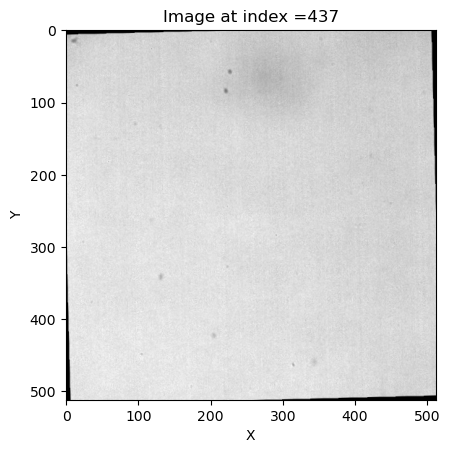

In [29]:
# change value here
array_to_show = empty_images

# nothing to do here
idx = random.randint(0, len(array_to_show) - 1)
plt.imshow(array_to_show[idx], cmap='gray')
plt.title("Image at index =" + str(idx))
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Creating labels for the images - GT 
- 3 arrays of size (N, 1) where N = no of samples

after data aug, we have 600 samples for each class

In [31]:
labels_empty = createLabelsArray(600, 'empty')
labels_droplets = createLabelsArray(600, 'droplet')
labels_aggregates = createLabelsArray(600, 'aggregates')

print("Shape of labels array (no samples,) =", labels_empty.shape)

Shape of labels array (no samples,) = (600,)


### Saving training data 

In [33]:
train_images = np.vstack((empty_images, droplets_images, non_droplets_images))
train_labels = np.hstack((labels_empty, labels_droplets, labels_aggregates))

print("Shape of the merged array of all training images", train_images.shape)
print("Shape of the labels for all training images", train_labels.shape)

np.save(join(savepath, "training_images_600"), train_images)
np.save(join(savepath, "training_labels_600"), train_labels)

Shape of the merged array of all training images (1800, 512, 512)
Shape of the labels for all training images (1800,)
